# Data visualization

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import plotting_tools
import utils
import symb_reg as sr
import matplotlib.pyplot as plt

from deap import tools

import numpy as np
import pickle

## Load data

In [8]:
data_paths = ('data/adaptive_size_test', 'data/f2_1e7_evals_exact')
exp1 = list(map(utils.LoadedLogs, data_paths)), ['adaptive size', 'fixed size 32']

In [9]:
data = np.load(data_paths[0] + '/dataset.npz')
trn_x, trn_y = data['trn_x'], data['trn_y']
exp, names = exp1

## Plot performance

<IPython.core.display.Javascript object>


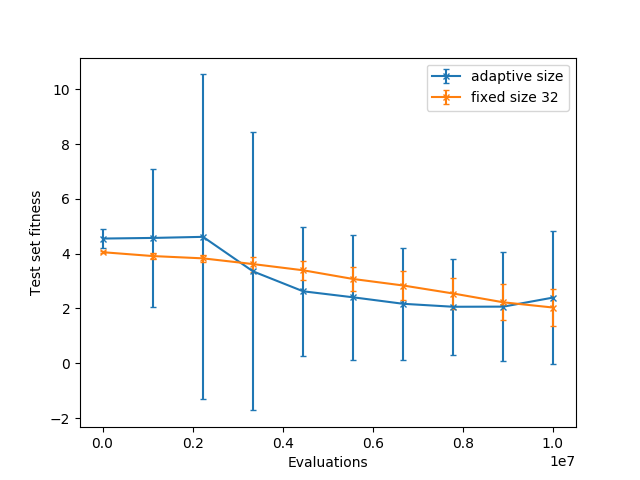

In [10]:
plotting_tools.compare_performance(exp, 'evals', 'test_set_f', method_names=names, ignore_tresh=1000, xlabel='Evaluations', ylabel='Test set fitness')
plt.show()

In [19]:
# select runs
runs = list(list(exp)[0])

## Histogram of test set fitnesses

In [12]:
plt.hist([l[-1]['test_set_f'] for l in runs])
plt.show()

In [21]:
sorted_logs = sorted(runs, key=lambda x: x[-1]['test_set_f'])
# select run you want to analyze
log = sorted_logs[3] # best run

## Performance of the run

<IPython.core.display.Javascript object>


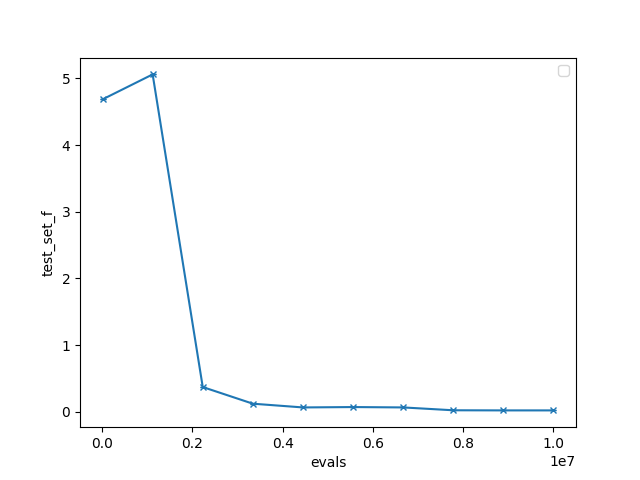

0.019464841823109168


<IPython.core.display.Javascript object>


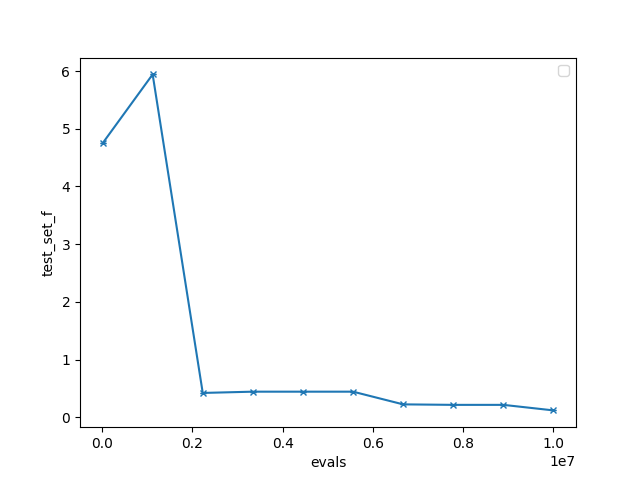

0.11889605230490309


<IPython.core.display.Javascript object>


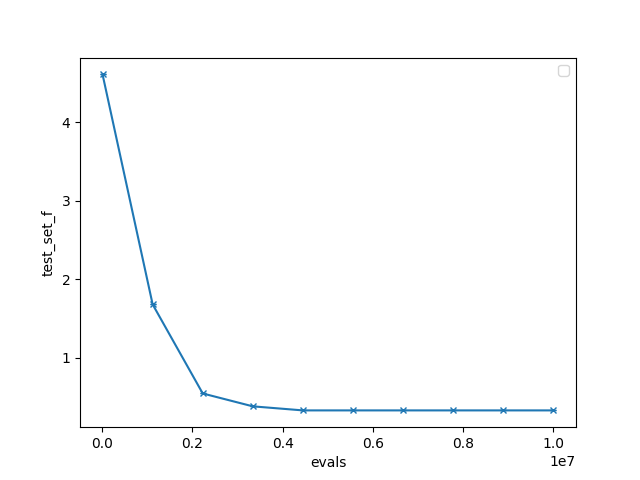

0.3277503261127254


<IPython.core.display.Javascript object>


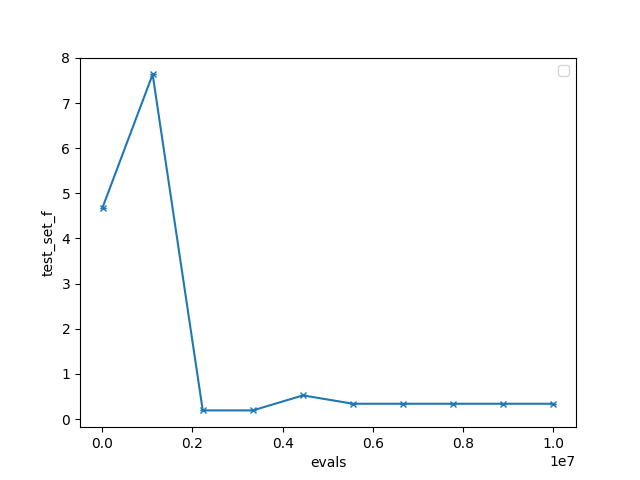

0.3397942773629389


<IPython.core.display.Javascript object>


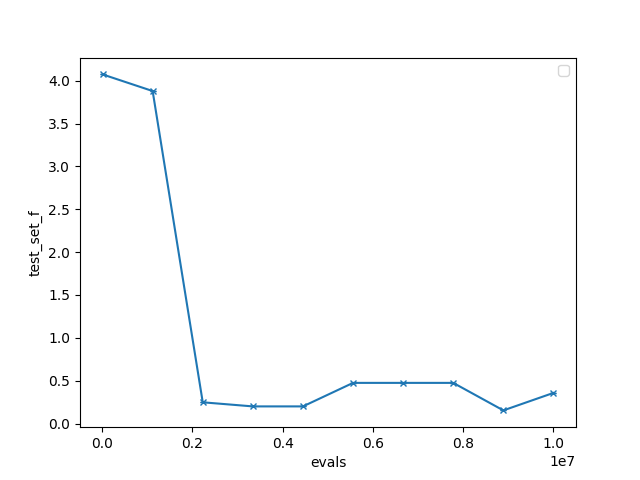

0.3574861372184137


<IPython.core.display.Javascript object>


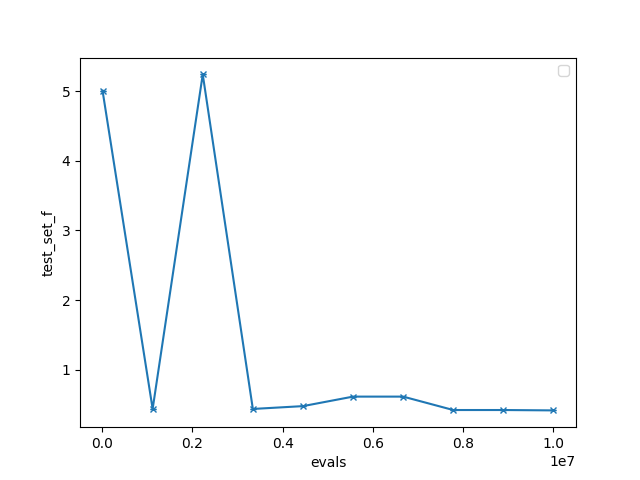

0.4155305162771662


<IPython.core.display.Javascript object>


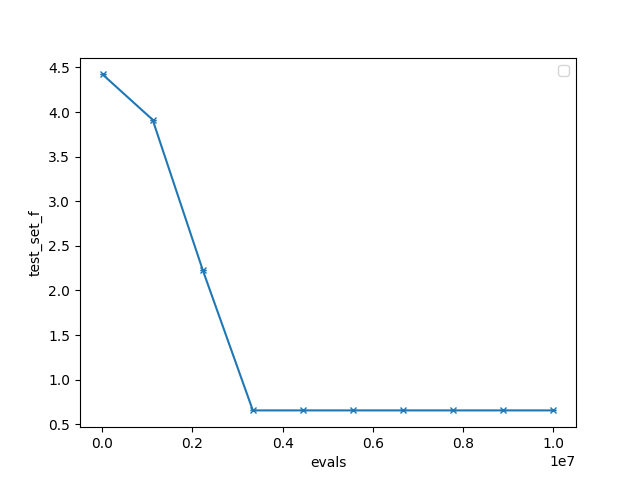

0.6545655440708541


<IPython.core.display.Javascript object>


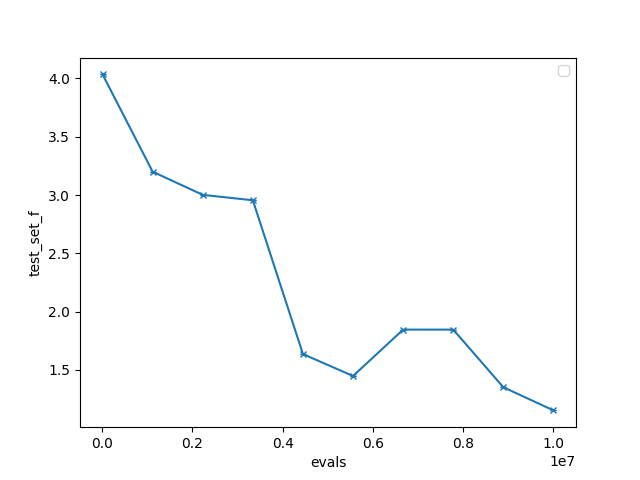

1.1527330227245278


<IPython.core.display.Javascript object>


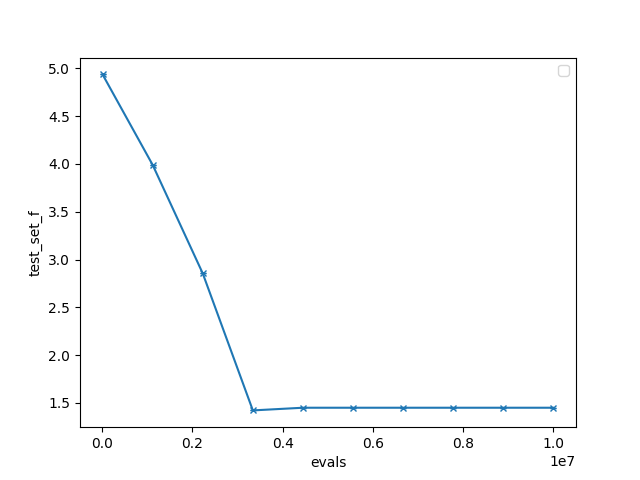

1.4502971330055336


<IPython.core.display.Javascript object>


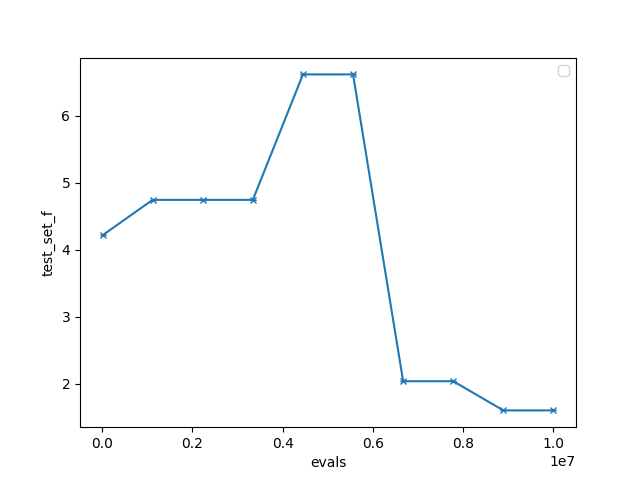

1.6001883520014806


<IPython.core.display.Javascript object>


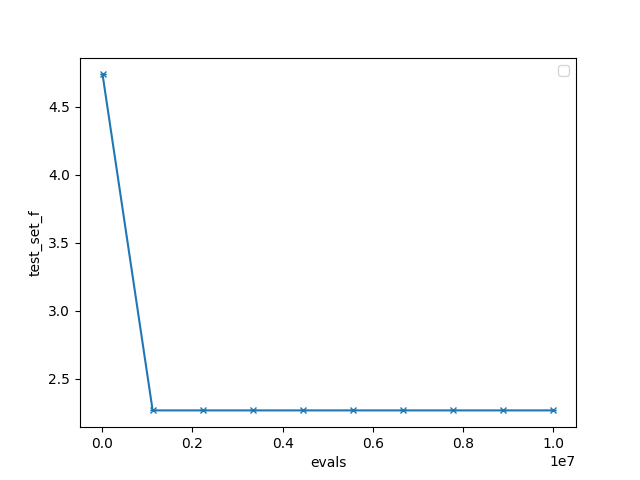

2.2692319617096803


<IPython.core.display.Javascript object>


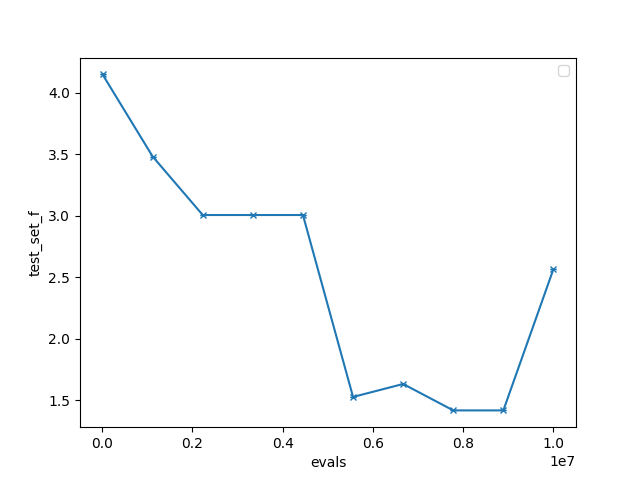

2.5657582273001838


<IPython.core.display.Javascript object>


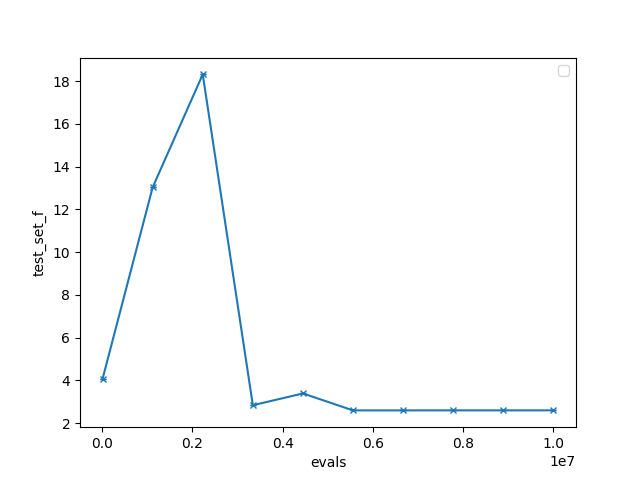

2.6030944197356787


<IPython.core.display.Javascript object>


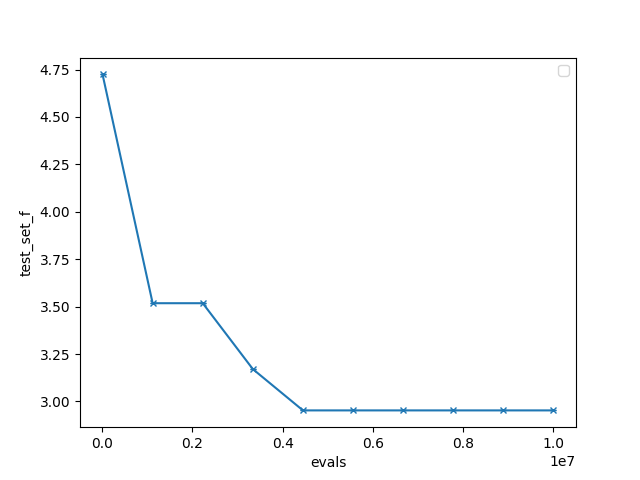

2.9529234080816438


<IPython.core.display.Javascript object>


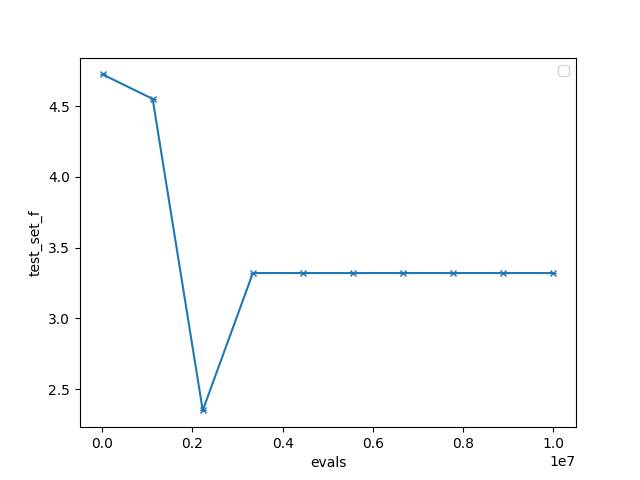

3.3210353757997226


<IPython.core.display.Javascript object>


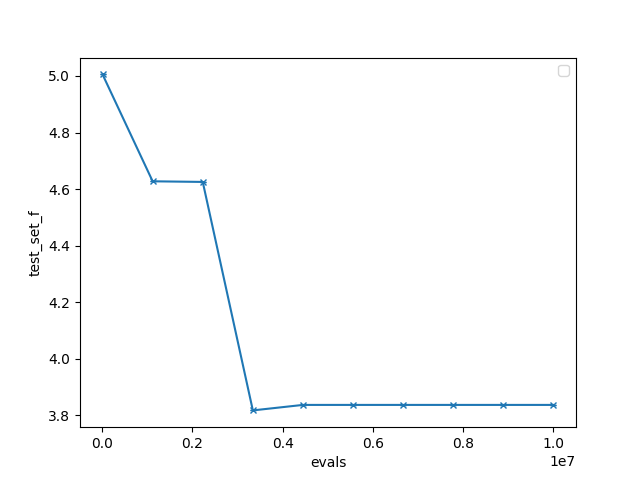

3.837013612110199


<IPython.core.display.Javascript object>


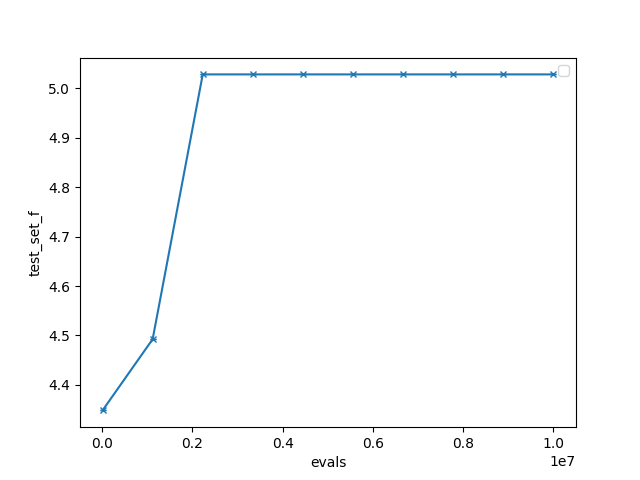

5.028244380438342


<IPython.core.display.Javascript object>


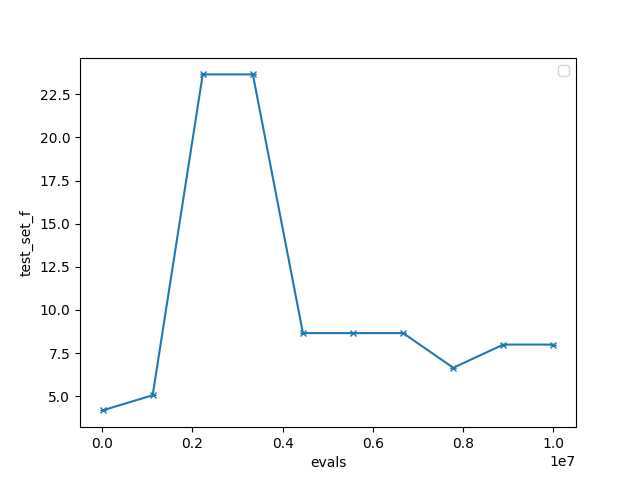

7.992500222088007


<IPython.core.display.Javascript object>


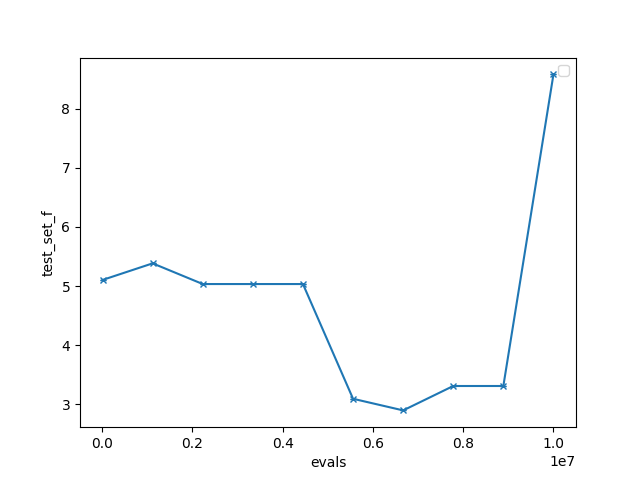

8.581387271189728


In [14]:
for l in sorted_logs:
    plotting_tools.show_performance(l, 'evals', 'test_set_f')
    print(l.select('test_set_f')[-1])

## Found solution

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


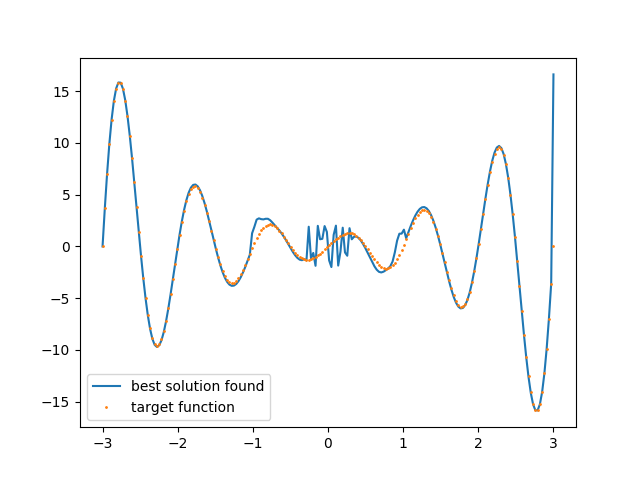

In [22]:
fig, ax = plt.subplots()
ax.plot(trn_x, log[-1]['best_sol_vals'], label='best solution found')
ax.plot(trn_x, trn_y, ls=' ', marker='o', ms='1', label='target function')
ax.legend()
plt.show()

## Histogram of used predictors

<IPython.core.display.Javascript object>


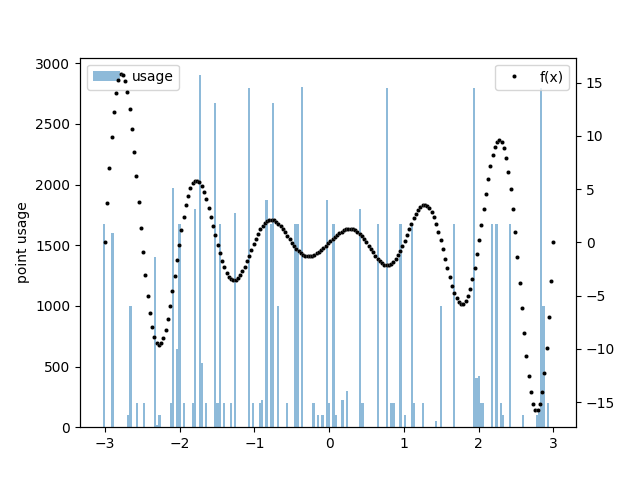

In [23]:
plotting_tools.predictor_histogram(trn_x, trn_y, log)
plt.show()

## Animation of the progress of the run

<IPython.core.display.Javascript object>


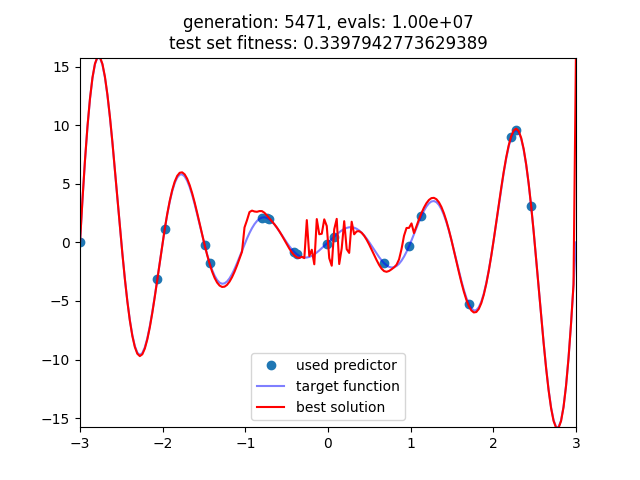

In [24]:
anim = plotting_tools.visualize_run(trn_x, trn_y, log, freq=50, step=10)
plt.show()